In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1" #To avoid warning for using K-Means Clustering

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


In [2]:
df = pd.read_csv('_dataset.csv')  
df.head()

,Accuracy (%),Reaction Time (s)
0,78.2,2.45
1,85.6,2.30
2,91.0,2.18
3,73.5,2.60
4,88.9,2.25


In [3]:
#Here, we see the Accuracy (range 70-95) would dominate Reaction Time (range 2.1-2.6) in distance calculations. That's why we are scaling the data
preprocessor = ColumnTransformer(
    transformers=[
        ("scaler", StandardScaler(), ['Accuracy (%)', 'Reaction Time (s)'])
    ],
    remainder="drop" 
)
X = df[["Accuracy (%)", "Reaction Time (s)"]]
X_preprocessed = preprocessor.fit_transform(X)
X_preprocessed

array([[-1.03992348,  0.79793729],
       [ 0.1578094 , -0.21531641],
       [ 1.03183069, -1.02591937],
       [-1.80064572,  1.81119099],
       [ 0.69193352, -0.55306765],
       [-0.36012914,  0.12243482],
       [ 1.53358366, -1.56632135],
       [-1.2665216 ,  1.47343976],
       [ 0.82141816, -0.75571839],
       [-0.53817052,  0.46018606],
       [ 1.43647018, -1.43122085],
       [-1.13703696,  1.13568852],
       [ 0.41677867, -0.35041691],
       [-0.11734545, -0.01266567],
       [ 0.9509028 , -0.89081888],
       [-0.78095421,  1.00058803]])

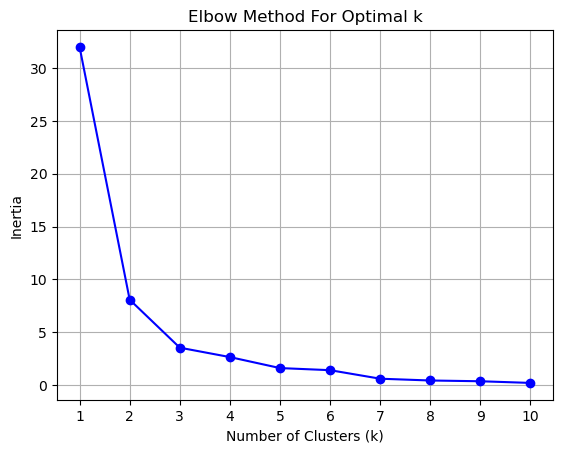

In [4]:
#Now before using K-Means clustering, we have to find the best value of K. That's why we use Elbow Method
inertias = []
k_values = range(1, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_preprocessed)
    inertias.append(kmeans.inertia_)
#Plotting the graph using Matplotlib
plt.plot(k_values, inertias, 'bo-')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method For Optimal k")
plt.grid(True)
plt.xticks(k_values)
plt.show()


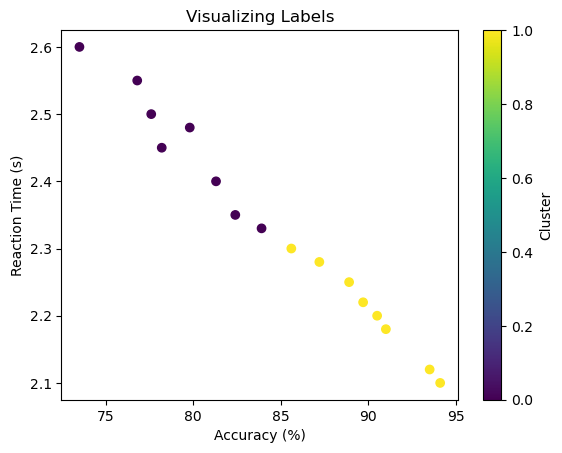

In [5]:
#From the graph we see, At K=1 to K=2 the value of intertia signeficantly drops. That's why we are choosing K=2
k = 2
kmeans = KMeans(n_clusters=k, random_state=42)
df["Cluster"] = kmeans.fit_predict(X_preprocessed)

# Visualize clusters, here the clusters are labeled as 0 and 1
plt.scatter(df["Accuracy (%)"], df["Reaction Time (s)"], c=df["Cluster"], cmap="viridis")
plt.xlabel("Accuracy (%)")
plt.ylabel("Reaction Time (s)")
plt.title("Visualizing Labels")
plt.colorbar(label="Cluster")
plt.show()

In [6]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_preprocessed, df["Cluster"], test_size=0.2, random_state=42
)
#We will use Pipeline for clean code visualization and GridSearchCV for hyperparameter tuning
models = {
    "SVM": Pipeline([
        ("classifier", SVC(random_state=42))
    ]),
    "Decision Tree": Pipeline([
        ("classifier", DecisionTreeClassifier(random_state=42))
    ])
}

param_grids = {
    "SVM": {
        "classifier__C": [0.1, 0.3, 0.8, 1, 3, 6, 10],
        "classifier__kernel": ["linear", "rbf", "poly"]
    },
    "Decision Tree": {
        "classifier__criterion": ["gini", "entropy"],
        "classifier__max_depth": [None, 2, 5, 7, 10, 15, 20]
    }
}

best_params = {}

#Now looping through models for finding best models
for name, model in models.items():
    print(f"\n Tuning {name}...")
    
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grids[name],
        cv=5,
        scoring="accuracy",
        n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)
    
    print(f" Best Parameters for {name}: {grid_search.best_params_}")
    print(f" Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}")
    
    # Saving the best estimator
    best_params[name] = grid_search.best_estimator_



 Tuning SVM...
 Best Parameters for SVM: {'classifier__C': 0.1, 'classifier__kernel': 'linear'}
 Best Cross-Validation Accuracy: 0.9333

 Tuning Decision Tree...
 Best Parameters for Decision Tree: {'classifier__criterion': 'gini', 'classifier__max_depth': None}
 Best Cross-Validation Accuracy: 1.0000


In [7]:
#Best parameters of each model:
best_params

{'SVM': Pipeline(steps=[('classifier', SVC(C=0.1, kernel='linear', random_state=42))]),
 'Decision Tree': Pipeline(steps=[('classifier', DecisionTreeClassifier(random_state=42))])}

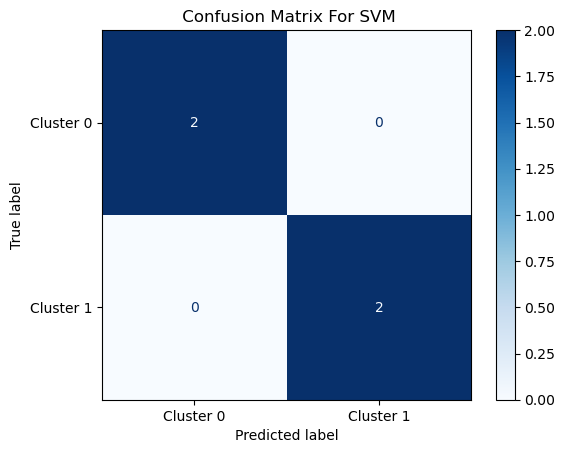

In [8]:
#Training SVM Model
best_params['SVM'].fit(X_train, y_train)
y_pred = best_params['SVM'].predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['Cluster 0', 'Cluster 1'])
disp.plot(cmap='Blues')
plt.title(f' Confusion Matrix For SVM')
plt.show()

Decision Tree Accuracy: 1.00


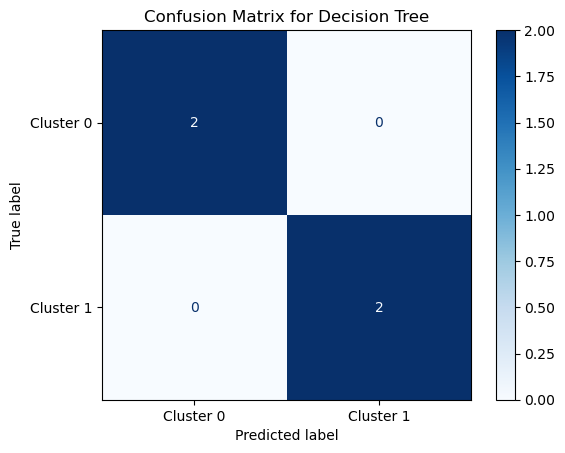

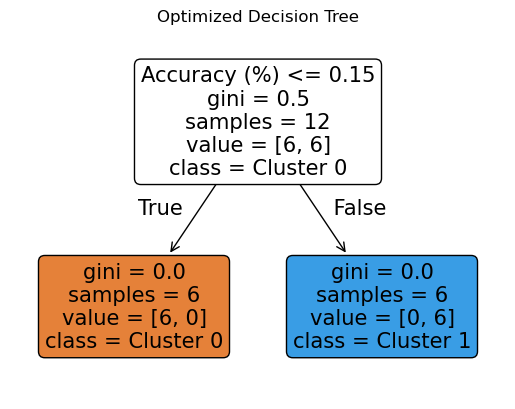

In [17]:
#Training Decision Tree Model with best Parameters
dt = best_params['Decision Tree'].fit(X_train, y_train)  
y_pred = dt.predict(X_test)  

accuracy = accuracy_score(y_test, y_pred)
print(f"Decision Tree Accuracy: {accuracy:.2f}")

#Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['Cluster 0', 'Cluster 1'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for Decision Tree')
plt.show()

#Visualize the Decision Tree
# Extracting the actual DecisionTreeClassifier from the pipeline
tree_classifier = dt.named_steps['classifier']  # Access the classifier step in the pipeline
plot_tree(tree_classifier,  
          feature_names=['Accuracy (%)', 'Reaction Time (s)'], 
          class_names=['Cluster 0', 'Cluster 1'],
          filled=True, 
          rounded=True)
plt.title("Optimized Decision Tree")
plt.show()

In [18]:
print(f"Total samples: {len(X_preprocessed)}")
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

Total samples: 16
Training samples: 12
Test samples: 4
